## Code file for Problem 3.

In [0]:
###Code to obtain data via Kaggle API

# !kaggle datasets download "paultimothymooney/breast-histopathology-images"
# !unzip breast-histopathology-images.zip
# !unzip IDC_regular_ps50_idx5.zip

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
import random
from os import listdir
from glob import glob
import cv2
import matplotlib.pyplot as plt
import fnmatch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import EarlyStopping
import seaborn as sns



**Getting data from the content directory, printing 16 random images from the dataset after resizing them to (50,50)** 

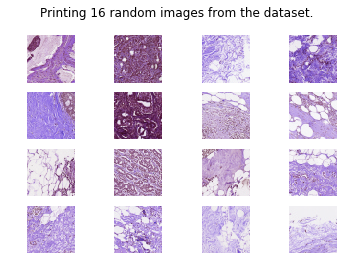

In [8]:
image_data = glob('../content/**/*.png', recursive=True)

index = 0
fig=plt.figure()
for image in random.sample(image_data,16):
    img = cv2.resize(cv2.imread(image), (50, 50))
    ax=fig.add_subplot(4, 4, index+1)  
    ax.imshow(img)
    ax.axis('off')
    index += 1
fig.suptitle('Printing 16 random images from the dataset.')
plt.show()

**Getting a list of label_0 and label_1 image files, storing images in list X and associated labels in list y. 50k images sampled randomly for this assignment.**

In [14]:
label_0 = fnmatch.filter(image_data, '*class0.png')
label_1 = fnmatch.filter(image_data, '*class1.png')

X = list()
y = list()
for image in random.sample(image_data, 50000):
    img = cv2.resize(cv2.imread(image),(40,40))
    X.append(img)
    if image in label_0:
        y.append(0)
    else:
        y.append(1)


print('The shape of each X element : ',X[0].shape)
print('Total number of images : ',len(X))

The shape of each X element :  (40, 40, 3)
Total number of images :  50000


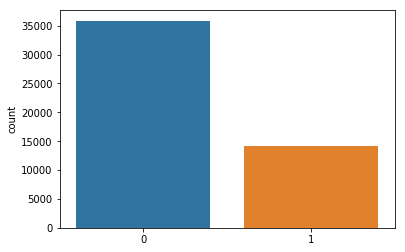

In [18]:
sns.countplot(y)

**Looking at the above countplot, the classes are highly imbalanced (looks like ~(70%-30%)) - this can be handled by undersampling the majority label (i.e label 0).**

In [44]:
X = list()
y = list()
count_0 = 0
for image in random.sample(image_data, 50000):
    img = cv2.resize(cv2.imread(image),(40,40))
    if image in label_0:
        if count_0 <= 15000:
            X.append(img)
            y.append(0)
            count_0 += 1
    else:
        X.append(img)
        y.append(1)


print('The shape of each X element : ',X[0].shape)
print('Total number of images : ',len(X))


The shape of each X element :  (40, 40, 3)
Total number of images :  29119


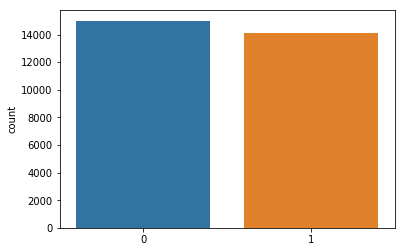

In [45]:
sns.countplot(y)

**The code block above will reduce the imbalance by sampling from both classes in similar measure, resulting countplot shows the reduced imbalance. y is converted to categorical data.**

In [0]:
num_classes = 2 

X_arr=np.array(X)
X_arr=X_arr/255.0

X_trainval, X_test, y_trainval, y_test = train_test_split(X_arr, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)


### 3.1

**Generating the training, validation and test datasets. 80-20 split employed. Constructing a simple Model with Batch normalization.**

In [76]:

input_shape = (40, 40, 3)
from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization
num_classes = 2
cnn = Sequential()
cnn.add(Conv2D(8, kernel_size=(3, 3),
                 activation='tanh',
                 input_shape=input_shape))
cnn.add(Activation("tanh"))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Conv2D(8, (3, 3), activation='tanh'))
cnn.add(Activation("tanh"))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(64, activation='tanh'))
cnn.add(Dense(2, activation='softmax'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
sgd = optimizers.SGD(lr=0.00005, decay=1e-6, momentum=0.9, nesterov=True)
cnn.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=['accuracy'])
history_cnn = cnn.fit(X_train, y_train,
                      batch_size=128, epochs=20, verbose=1, validation_data = [X_val, y_val],callbacks=[es])



Train on 18636 samples, validate on 4659 samples
Epoch 1/20
18636/18636 [==============================] - 37s 2ms/step - loss: 0.6312 - acc: 0.6836 - val_loss: 0.5628 - val_acc: 0.7405
Epoch 2/20
18636/18636 [==============================] - 36s 2ms/step - loss: 0.5727 - acc: 0.7326 - val_loss: 0.5503 - val_acc: 0.7523
Epoch 3/20
18636/18636 [==============================] - 35s 2ms/step - loss: 0.5596 - acc: 0.7387 - val_loss: 0.5433 - val_acc: 0.7566
Epoch 4/20
18636/18636 [==============================] - 36s 2ms/step - loss: 0.5491 - acc: 0.7451 - val_loss: 0.5404 - val_acc: 0.7534
Epoch 5/20
18636/18636 [==============================] - 35s 2ms/step - loss: 0.5400 - acc: 0.7519 - val_loss: 0.5270 - val_acc: 0.7624
Epoch 6/20
18636/18636 [==============================] - 35s 2ms/step - loss: 0.5342 - acc: 0.7520 - val_loss: 0.5246 - val_acc: 0.7652
Epoch 7/20
18636/18636 [==============================] - 35s 2ms/step - loss: 0.5257 - acc: 0.7574 - val_loss: 0.5205 - val_acc:

**Model gives a validation accuracy of 0.783 finally. Below is the plotted curve.**

**Also note that 'early stopping' function has been defined for all of the following models that has patience parameter set to 3 (for the validation accuracy), i.e 3 consecutive drops in validation accuracy will cause the model to stop iterating.**

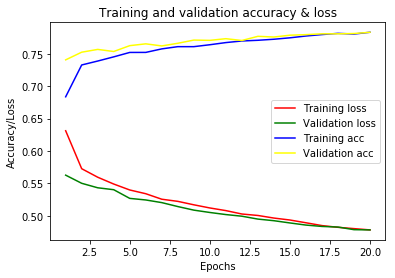

In [77]:
import matplotlib.pyplot as plt

train_acc = history_cnn.history['acc']
val_acc = history_cnn.history['val_acc']
train_loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, 'red', label='Training loss')

plt.plot(epochs, val_loss, 'green', label='Validation loss')

plt.plot(epochs, train_acc, 'blue', label='Training acc')

plt.plot(epochs, val_acc, 'yellow', label='Validation acc')

plt.title('Training and validation accuracy & loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()

plt.show()

**The plot above looks consistent - loss goes down and accuracy goes higher as we move through epochs.**

### 3.2

In [78]:
datagen = ImageDataGenerator(
    vertical_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
# the imagedatagenerator fits our model on several augmentations of the images.
history = cnn.fit_generator(datagen.flow(X_train,y_train, batch_size=32),steps_per_epoch=len(X_train)/32,
                    epochs=20, verbose=1, validation_data = [X_val, y_val],callbacks=[es])

Epoch 1/20
583/582 [==============================] - 49s 83ms/step - loss: 0.4853 - acc: 0.7776 - val_loss: 0.5226 - val_acc: 0.7635
Epoch 2/20
583/582 [==============================] - 49s 84ms/step - loss: 0.4791 - acc: 0.7807 - val_loss: 0.5414 - val_acc: 0.7463
Epoch 3/20
583/582 [==============================] - 49s 84ms/step - loss: 0.4763 - acc: 0.7811 - val_loss: 0.4765 - val_acc: 0.7894
Epoch 4/20
583/582 [==============================] - 49s 83ms/step - loss: 0.4689 - acc: 0.7907 - val_loss: 0.4761 - val_acc: 0.7899
Epoch 5/20
583/582 [==============================] - 49s 85ms/step - loss: 0.4617 - acc: 0.7905 - val_loss: 0.5701 - val_acc: 0.7220
Epoch 6/20
583/582 [==============================] - 49s 84ms/step - loss: 0.4591 - acc: 0.7912 - val_loss: 0.4545 - val_acc: 0.8051
Epoch 7/20
583/582 [==============================] - 49s 84ms/step - loss: 0.4587 - acc: 0.7937 - val_loss: 0.4521 - val_acc: 0.8000
Epoch 8/20
583/582 [==============================] - 49s 84ms

**The Image Data Generator employed above does increase the validation accuracy - it goes from 0.78 to 0.81 in this case.**

**Image Data Generator performs several augmentations on the image, like flips, rotations, etc.**

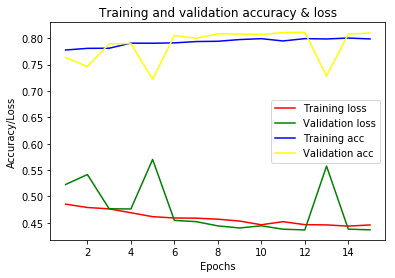

In [79]:
import matplotlib.pyplot as plt

train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)


plt.plot(epochs, train_loss, 'red', label='Training loss')

plt.plot(epochs, val_loss, 'green', label='Validation loss')

plt.plot(epochs, train_acc, 'blue', label='Training acc')

plt.plot(epochs, val_acc, 'yellow', label='Validation acc')

plt.title('Training and validation accuracy & loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()

plt.show()

**The plot for the losses and accuracies is again consistent with our expected results, imagedatagenerator increases the accuracy wrt the previous model.**

### 3.3 

**Now we move on to building deeper models - the given network has layers conv1_1,conv1_2 ....through conv14_2.**

**We first start with a network without the residual connections.**


In [86]:
input_shape = (40, 40, 3)
from keras.layers import Input,Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.models import Model

num_classes = 2

model = {}

inputs = Input(shape=(40, 40, 3))
model["conv1_1"] = Conv2D(5, (3, 3), activation='tanh',
                 padding='same')(inputs)
model["conv1_2"] = Conv2D(5, (3, 3), activation='tanh',
                 padding='same')(model["conv1_1"])


for i in range(2,15,1):
    model["conv{0}_1".format(i)] =  Conv2D(5, (3, 3), activation='tanh',
                 padding='same')(model["conv{0}_2".format(i-1)])
    model["conv{0}_2".format(i)] = Conv2D(5, (3, 3), activation='tanh',
                 padding='same')(model["conv{0}_1".format(i)])
  

maxpool5 = MaxPooling2D(pool_size=(2, 2))(model["conv{0}_2".format(i-1)])

flat = Flatten()(maxpool5)
dense = Dense(64, activation='relu')(flat)
predictions = Dense(num_classes, activation='softmax')(dense)
model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_deep_without_resid = model.fit_generator(datagen.flow(X_train,y_train, batch_size=32),steps_per_epoch=len(X_train)/32,
                    epochs=10, verbose=1, validation_data = [X_val, y_val],callbacks=[es])



Epoch 1/10
583/582 [==============================] - 581s 997ms/step - loss: 0.6886 - acc: 0.5926 - val_loss: 0.6830 - val_acc: 0.6514
Epoch 2/10
583/582 [==============================] - 579s 992ms/step - loss: 0.6791 - acc: 0.6403 - val_loss: 0.6645 - val_acc: 0.6838
Epoch 3/10
583/582 [==============================] - 582s 999ms/step - loss: 0.6233 - acc: 0.6910 - val_loss: 0.5686 - val_acc: 0.7190
Epoch 4/10
583/582 [==============================] - 579s 992ms/step - loss: 0.5269 - acc: 0.7493 - val_loss: 0.4698 - val_acc: 0.7864
Epoch 5/10
583/582 [==============================] - 578s 992ms/step - loss: 0.4810 - acc: 0.7808 - val_loss: 0.4761 - val_acc: 0.7804
Epoch 6/10
583/582 [==============================] - 577s 989ms/step - loss: 0.4756 - acc: 0.7840 - val_loss: 0.4626 - val_acc: 0.7909
Epoch 7/10
583/582 [==============================] - 578s 992ms/step - loss: 0.4723 - acc: 0.7849 - val_loss: 0.4705 - val_acc: 0.7851
Epoch 8/10
583/582 [============================

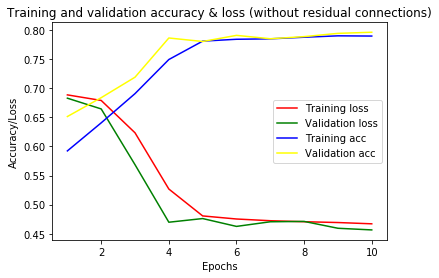

In [87]:
import matplotlib.pyplot as plt

train_acc = history_deep_without_resid.history['acc']
val_acc = history_deep_without_resid.history['val_acc']
train_loss = history_deep_without_resid.history['loss']
val_loss = history_deep_without_resid.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, 'red', label='Training loss')

plt.plot(epochs, val_loss, 'green', label='Validation loss')

plt.plot(epochs, train_acc, 'blue', label='Training acc')

plt.plot(epochs, val_acc, 'yellow', label='Validation acc')

plt.title('Training and validation accuracy & loss (without residual connections)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()

plt.show()

**Following is the plot for the accuracy and losses obtained - and are in line with expected trends wrt increasing epoch. The model stops at a validation accuracy of 0.793**

**Moving on to a Network with residual connections applied every alternate layer - i.e from layer 1,2 -> 3, and so on.**

In [97]:
num_classes = 2

model = {}

inputs = Input(shape=(40, 40, 3))
model["conv1_1"] = Conv2D(5, (3, 3), activation='tanh',
                 padding='same')(inputs)
model["conv1_2"] = Conv2D(5, (3, 3), activation='tanh',
                 padding='same')(model["conv1_1"])


for i in range(2,15,1):
  
    if i%2 != 0:
        feed = skip
    else:
        feed = model["conv{0}_2".format(i-1)]
    model["conv{0}_1".format(i)] =  Conv2D(5, (3, 3), activation='tanh',
                 padding='same')(feed)
    model["conv{0}_2".format(i)] = Conv2D(5, (3, 3), activation='tanh',
                 padding='same')(model["conv{0}_1".format(i)])
  
    if i%2 == 0:
        skip = keras.layers.Add()([model["conv{0}_2".format(i-1)],model["conv{0}_2".format(i)]])
  
maxpool5 = MaxPooling2D(pool_size=(2, 2))(model["conv{0}_2".format(i-1)])

flat = Flatten()(maxpool5)
dense = Dense(64, activation='relu')(flat)
predictions = Dense(num_classes, activation='softmax')(dense)
model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_deep_without_resid = model.fit_generator(datagen.flow(X_train,y_train, batch_size=32),steps_per_epoch=len(X_train)/32,
                    epochs=10, verbose=1, validation_data = [X_val, y_val],callbacks=[es])


Epoch 1/10
583/582 [==============================] - 590s 1s/step - loss: 0.6412 - acc: 0.6417 - val_loss: 0.5857 - val_acc: 0.6954
Epoch 2/10
583/582 [==============================] - 584s 1s/step - loss: 0.5348 - acc: 0.7419 - val_loss: 0.5738 - val_acc: 0.7315
Epoch 3/10
583/582 [==============================] - 581s 997ms/step - loss: 0.4841 - acc: 0.7772 - val_loss: 0.7073 - val_acc: 0.5754
Epoch 4/10
583/582 [==============================] - 577s 990ms/step - loss: 0.4680 - acc: 0.7877 - val_loss: 0.5264 - val_acc: 0.7495
Epoch 5/10
583/582 [==============================] - 575s 986ms/step - loss: 0.4598 - acc: 0.7950 - val_loss: 0.4627 - val_acc: 0.7950
Epoch 6/10
583/582 [==============================] - 571s 979ms/step - loss: 0.4558 - acc: 0.7969 - val_loss: 0.4380 - val_acc: 0.8066
Epoch 7/10
583/582 [==============================] - 573s 982ms/step - loss: 0.4483 - acc: 0.8016 - val_loss: 0.4346 - val_acc: 0.8096
Epoch 8/10
583/582 [==============================] - 

**A slightly higher validation accuracy of 0.805 is obtained - up from 0.793. Residual connections show a marginal increase, though real effects would be visible on much larger networks.**

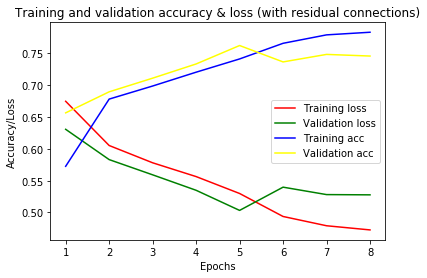

In [98]:
import matplotlib.pyplot as plt

train_acc = history_deep.history['acc']
val_acc = history_deep.history['val_acc']
train_loss = history_deep.history['loss']
val_loss = history_deep.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, 'red', label='Training loss')

plt.plot(epochs, val_loss, 'green', label='Validation loss')

plt.plot(epochs, train_acc, 'blue', label='Training acc')

plt.plot(epochs, val_acc, 'yellow', label='Validation acc')

plt.title('Training and validation accuracy & loss (with residual connections)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()

plt.show()

**Plotting the accuracies and losses - early stopping stopped the model at the 8th epoch, and hence the increase in loss towards the end. Patience parameter was set to 3, so the model stopped appropriately.**